In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import random
from tqdm import *

In [69]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)

#runner = runner.dropna()
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)
join = join.loc[~join.runner_id.isna()]

In [45]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128749 entries, 0 to 130136
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          128749 non-null  int64         
 1   ranking               112204 non-null  float64       
 2   runner                128749 non-null  object        
 3   time                  112204 non-null  object        
 4   age                   128749 non-null  float64       
 5   gender                128720 non-null  object        
 6   nationality           128749 non-null  object        
 7   time_in_seconds       112204 non-null  float64       
 8   runner_id             128720 non-null  object        
 9   age_course            128749 non-null  float64       
 10  age_range             128749 non-null  category      
 11  speed                 112204 non-null  float64       
 12  equivalent_speed      112204 non-null  float64       
 13 

In [46]:
join.loc[join.time_in_seconds.isna()]

,race_year_id,ranking,runner,time,age,gender,nationality,time_in_seconds,runner_id,age_course,...,participants,country_code,year,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation,date,relative_ranking
13,68140,NaN,BEDDOW Charlotte,NaN,49.0,W,GBR,NaN,BEDDOWCharlotteGBRW49.0,49.0,...,150,GBR,2021,9,3,25,212.1,0.213107,2021-09-03,NaN
14,68140,NaN,COOKE Matthew,NaN,41.0,M,GBR,NaN,COOKEMatthewGBRM41.0,41.0,...,150,GBR,2021,9,3,25,212.1,0.213107,2021-09-03,NaN
15,68140,NaN,COSSEY WATSON Bev,NaN,40.0,W,GBR,NaN,COSSEYWATSONBevGBRW40.0,40.0,...,150,GBR,2021,9,3,25,212.1,0.213107,2021-09-03,NaN
16,68140,NaN,FAIRS Robert,NaN,35.0,M,GBR,NaN,FAIRSRobertGBRM35.0,35.0,...,150,GBR,2021,9,3,25,212.1,0.213107,2021-09-03,NaN
17,68140,NaN,HARRIS Charles,NaN,47.0,M,GBR,NaN,HARRISCharlesGBRM47.0,47.0,...,150,GBR,2021,9,3,25,212.1,0.213107,2021-09-03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99692,8089,NaN,macdonald Alastair,NaN,56.0,M,GBR,NaN,macdonaldAlastairGBRM56.0,49.0,...,12,IDN,2014,11,7,12,257.4,0.332945,2014-11-07,NaN
99693,8089,NaN,MCGRATH Michael,NaN,57.0,M,AUS,NaN,MCGRATHMichaelAUSM57.0,50.0,...,12,IDN,2014,11,7,12,257.4,0.332945,2014-11-07,NaN
99694,8089,NaN,SIDIK Apriyandi,NaN,28.0,M,INA,NaN,SIDIKApriyandiINAM28.0,21.0,...,12,IDN,2014,11,7,12,257.4,0.332945,2014-11-07,NaN
99695,8089,NaN,SURACHMAN Surachman,NaN,71.0,M,INA,NaN,SURACHMANSurachmanINAM71.0,64.0,...,12,IDN,2014,11,7,12,257.4,0.332945,2014-11-07,NaN


In [124]:
def multiple_runner_profile(join, race, race_year_id_list):
    #Collect data from course
    #Return df
    huge_df = pd.DataFrame()
    
    for race_year_id_to_predict in tqdm(race_year_id_list):
        df = pd.DataFrame()
        race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
        race_year_id = race_to_predict.iloc[0]['race_year_id']
        date_to_predict = race_to_predict.iloc[0]['date']
        distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
        country_to_predict = race_to_predict.iloc[0]['country_code']


        unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
        for runner in unique_runners:
            runner_info = join.loc[(join.runner_id == runner) & (join.race_year_id == race_year_id)]
            runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
            

            # Data processing
            #General data
            rr_id =  ''.join([str(runner), str(race_to_predict.iloc[0].race_year_id)])
            runner_id = runner
            age = runner_info['age_course'].iloc[0]
            gender = runner_info['gender'].iloc[0]
            nationality = runner_info['nationality'].iloc[0]

            #Race information
            race_year_id = runner_info['race_year_id'].iloc[0]
            race_distance = runner_info['distance'].iloc[0]
            race_elevation_gain = runner_info['elevation_gain'].iloc[0]
            race_equivalent_distance = runner_info['equivalent_distance'].iloc[0]
            race_weighted_elevation = runner_info['weighted_elevation'].iloc[0]
            race_freq = runner_info['frequency_in_ranking'].iloc[0]


            #Processed data
            total_races = 0
            avg_relative_rank = 1
            max_relative_rank = 1
            min_relative_rank = 1

            total_elevation = 0
            avg_elevation = 0

            total_distance = 0
            avg_distance = 0
            min_distance = 0
            max_distance = 0

            total_eq_distance = 0
            avg_eq_distance = 0
            min_eq_distance = 0
            max_eq_distance = 0

            avg_runners = 0

            years_of_activity = 0
            last_year_activity = race_to_predict.year

            has_run = 0
            has_run_last_year = 0
            has_run_equivalent_course = 0
            avg_course_per_year = 0
            distance_previous_year = 0
            ranking_score = 0
            avg_speed = 0
            last_course_speed = 0
            home_country = 0
            avg_speed = 0
            avg_equivalent_speed = 0
            
            has_dropped_past = np.any(runner_past.ranking.isna())
            dropped = np.isnan(runner_info.iloc[0].time_in_seconds)
            
            




            if nationality == country_to_predict:
                home_country = 1

            if runner_past.size > 0:
                has_run = 1
                total_races = runner_past.shape[0]

                avg_relative_rank = runner_past.relative_ranking.mean()
                avg_rank = runner_past.ranking.mean()
                max_relative_rank = runner_past.relative_ranking.max()
                min_relative_rank = runner_past.relative_ranking.min()

                total_elevation = runner_past.elevation_gain.sum()
                avg_elevation = runner_past.elevation_gain.mean()

                total_distance =  runner_past.distance.sum()
                avg_distance = runner_past.distance.mean()
                min_distance = runner_past.distance.min()
                max_distance = runner_past.distance.max()

                total_eq_distance = runner_past.equivalent_distance.sum()
                avg_eq_distance = runner_past.equivalent_distance.mean()
                min_eq_distance = runner_past.equivalent_distance.min()
                max_eq_distance = runner_past.equivalent_distance.max()

                avg_runners = runner_past.frequency_in_ranking.mean()

                avg_speed = runner_past.equivalent_speed.mean()
                last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

                years_of_activity = int(race_to_predict.year) - int(runner_past.year.min())

                last_year_activity = runner_past.year.max()


                avg_speed = runner_past.speed.mean()
                avg_equivalent_speed = runner_past.equivalent_speed.mean()


                for i in range(len(runner_past)):
                    ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

                if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                    has_run_equivalent_course = 1

                year_interval = runner_past.year.max()- runner_past.year.min()
                if year_interval != 0:
                    avg_course_per_year = total_races / year_interval



            df = df.append({'rr_id' : rr_id,
                            'runner_id': runner_id,
                            'ranking': runner_info.iloc[0]['ranking'],
                            'relative_ranking': runner_info.iloc[0]['relative_ranking'],
                            'time_in_seconds': runner_info.iloc[0]['time_in_seconds'],
                            'age': age, 
                            'gender': gender, 
                            'nationality':nationality,
                            'n_races': total_races,
                            'ranking_score':ranking_score,
                            'avg_relative_rank': avg_relative_rank,
                            'max_relative_rank' : max_relative_rank,
                            'min_relative_rank' : min_relative_rank,
                            'total_elevation' : total_elevation,
                            'avg_elevation' : avg_elevation,
                            'total_distance' : total_distance,
                            'avg_distance' : avg_distance,
                            'min_distance' : min_distance,
                            'max_distance' : max_distance,
                            'total_eq_distance' : total_eq_distance,
                            'avg_eq_distance' : avg_eq_distance,
                            'min_eq_distance' : min_eq_distance,
                            'max_eq_distance' : max_eq_distance,
                            'avg_runners' : avg_runners,
                            'years_of_activity': years_of_activity,
                            'last_year_activity': last_year_activity,
                            'avg_speed': avg_speed,
                            'avg_equivalent_speed': avg_equivalent_speed,
                            'total_distance': total_distance,
                            'has_run': has_run,
                            'has_run_equivalent_course': has_run_equivalent_course,
                            'avg_course_per_year': avg_course_per_year,
                            'avg_speed': avg_speed,
                            'last_course_speed': last_course_speed,
                            'home_country': home_country,
                            'race_race_year_id' :race_year_id,
                            'race_distance' : race_distance,
                            'race_elevation_gain' : race_elevation_gain,
                            'race_equivalent_distance' : race_equivalent_distance,
                            'race_weighted_elevation' : race_weighted_elevation,
                            'race_freq' : race_freq,
                            'has_dropped_past': has_dropped_past,
                            'dropped': dropped
                           }, ignore_index = True)

        huge_df = huge_df.append(df, ignore_index=True)

                
    one_hot_gender = pd.get_dummies(huge_df['gender'], prefix = "gender")
    huge_df = huge_df.drop('gender',axis = 1)
    huge_df = huge_df.join(one_hot_gender)
    
    return huge_df

In [126]:
df = multiple_runner_profile(join, race, race.loc[race.year >=2018].race_year_id.unique())

100%|█████████████████████████████████████████| 512/512 [15:24<00:00,  1.81s/it]


In [127]:
from pathlib import Path  

filepath = Path('../../output/data_clean/training_logit_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

df.to_csv(filepath)  

In [300]:
df = pd.read_csv('../../output/data_clean/training_logit_data.csv', index_col=0)

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
import missingno as msno

In [302]:
df2 = df.drop(columns=['relative_ranking','ranking','time_in_seconds','ranking_score'])

In [303]:
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55284 entries, 0 to 59284
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rr_id                      55284 non-null  object 
 1   runner_id                  55284 non-null  object 
 2   age                        55284 non-null  float64
 3   nationality                55284 non-null  object 
 4   n_races                    55284 non-null  float64
 5   avg_relative_rank          55284 non-null  float64
 6   max_relative_rank          55284 non-null  float64
 7   min_relative_rank          55284 non-null  float64
 8   total_elevation            55284 non-null  float64
 9   avg_elevation              55284 non-null  float64
 10  total_distance             55284 non-null  float64
 11  avg_distance               55284 non-null  float64
 12  min_distance               55284 non-null  float64
 13  max_distance               55284 non-null  flo

In [304]:
df2.nationality = pd.Categorical(
    df2.nationality, categories=df2.nationality.unique(),ordered=False
)
df2.race_race_year_id = pd.Categorical(
    df2.race_race_year_id, categories=df2.race_race_year_id.unique(), ordered=False
)


df2 = df2.assign(
    nationality_cat = df2.nationality.cat.codes,
    race_year_id_cat = df2.race_race_year_id.cat.codes,
)
df2 = df2.drop(columns=['nationality','race_race_year_id','runner_id'])

In [305]:
age_range_types = pd.CategoricalDtype( 
    categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)

df2 = df2.assign( age_range = df2.age)
df2.age_range = pd.cut(df2.age_range, bins = [16,25,40,60,100], labels=['16-25','26-40','40-60','61+'])
df2.age_range = df2.age_range.astype(age_range_types)
df2.loc[pd.isna(df2.age_range), "age_range"] = 'Undefined'

In [306]:
df2 = df2.drop(columns="age")

In [315]:
X = df2.drop(columns=['rr_id','last_year_activity','age_range'])
y = df2[['age_range']]

In [316]:
y = y.assign(
    age_range_cat = y.age_range.cat.codes,
)
y  = y.age_range_cat

In [318]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
logreg=LogisticRegression(max_iter = 1000, n_jobs = 4, multi_class='multinomial', solver='lbfgs')
predicted = cross_val_predict(logreg, StandardScaler().fit_transform(X), y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.5651002098256277
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       894
           1       0.48      0.17      0.25     21747
           2       0.58      0.88      0.70     31311
           3       0.74      0.03      0.05      1332

    accuracy                           0.57     55284
   macro avg       0.45      0.27      0.25     55284
weighted avg       0.53      0.57      0.49     55284



/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
res = pd.DataFrame({'real':y.dropped,'pred':predicted})
len(res.loc[res.real==True])

12214

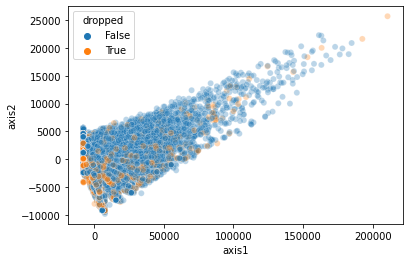

In [245]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = X

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['dropped'] = y


sns.scatterplot(x = "axis1", y = "axis2", hue ="dropped", data = X, alpha=0.3)
plt.savefig('test1.pdf')
